In [1]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tqdm import tqdm

In [2]:
with open('/kaggle/input/rml-splitting-80-20/data_200.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
#mod_list_new=['BPSK','QPSK','8PSK','QAM16','QAM64']

In [4]:
def load_data_for_test(data_dict,target_snr):
    signals = []
    labels = []
    
    # Iterate over the dictionary to filter data with the target SNR
    for (modulation, snr), signal_array in data_dict.items():
        #if snr==target_snr and modulation in mod_list_new:
        if snr==target_snr :
            for i in range((signal_array.shape)[0]):
                signal=signal_array[i]
                signals.append(signal)
                labels.append(modulation)
               
    print('Length of signals:',len(signals))
    signals = np.array(signals)
    print('Length of labels:',len(labels))
    labels=np.array(labels)
    return signals,labels

In [5]:
test_signals,test_mod=load_data_for_test(data,10)

Length of signals: 2200
Length of labels: 2200


In [6]:
labels_check=[]
for i in test_mod:
    if i not in labels_check:
        labels_check.append(i)
print(labels_check)

['BPSK', 'QPSK', '8PSK', 'PAM4', 'QAM16', 'QAM64', 'GFSK', 'CPFSK', 'WBFM', 'AM-DSB', 'AM-SSB']


In [7]:
phase_model=load_model('/kaggle/input/amc_hierarchy/keras/default/3/test_model_phase(10).keras')
non_phase_model=load_model('/kaggle/input/amc_hierarchy/keras/default/3/Non_Phase_Model (full).keras')
binary_model=load_model('/kaggle/input/amc_hierarchy/keras/default/3/Binary_model (full).keras')

In [8]:
def prediction_from_binary(frame):
    signal=np.swapaxes(frame,0,1)
    signal = np.expand_dims(signal, axis=0)
    signal = np.expand_dims(signal, axis=0)
    binary_pred=binary_model(signal)
    if binary_pred>=0.5:
        binary_pred=1
    else:
        binary_pred=0
    return binary_pred

In [9]:
np_labels=['PAM4', 'GFSK', 'CPFSK', 'WBFM', 'AM-DSB', 'AM-SSB']

In [10]:
p_labels=['8PSK', 'BPSK', 'QAM16', 'QAM64', 'QPSK']

In [11]:
def prediction_from_nonphase_model(frame):
    signal=np.swapaxes(frame,0,1)
    signal=np.expand_dims(signal,axis=0)
    signal=np.expand_dims(signal,axis=0)
    
    prediction=non_phase_model(signal)
    
    prediction=np.argmax(prediction,axis=1)
    
    mod_pred=np_labels[prediction[0]]
    
    return mod_pred

In [12]:
dir_path_new = f'/kaggle/working/test'
os.makedirs(dir_path_new, exist_ok=True)

In [13]:
"""for (modulation,snr) in data:
    if modulation in my_keys and snr in snr_vals:
        
        i=(modulation,snr)
        frames = data[i]

        # Create the directory if it doesn't exist
        dir_path = f'/kaggle/working/constellation/{i[0]}/'
        os.makedirs(dir_path, exist_ok=True)  # Create directory if it doesn't exist

        # Loop over the frames and generate the images
        for j in tqdm(range(0, 1600)):"""

dir_path="/kaggle/working/"
def plot_from_frame(frames):
    I = frames[0]
    Q = frames[1]

    # Plot the I-Q constellation
    fig = plt.figure(dpi=80)
    plt.plot(I, Q)
    plt.axis('off')

    # Save the plot to a temporary file
    plt.savefig('1.jpg')

    # Convert the image to grayscale
    im = Image.open('1.jpg').convert('L')

    # Save the grayscale image to the correct directory
    plot_path=f'{dir_path}/test1.jpg'
    im.save(plot_path)

    # Close the plot to free up memory
    plt.close()
    
    return plot_path
    
    

In [14]:
"""def plot_from_frame(frames):
    I = frames[0]
    Q = frames[1]

    # Plot the I-Q constellation diagram
    fig = plt.figure(dpi=80)
    plt.plot(I, Q)
    plt.axis('off')

    # Save the plot as a temporary image
    plt.savefig('new.jpg')
    
    plt.close(fig)

    # Convert the saved plot to grayscale and save it
    im = Image.open('new.jpg').convert('L')
    plot_path=f'{dir_path_new}/test.jpg'
    im.save(plot_path)
    return plot_path"""

"def plot_from_frame(frames):\n    I = frames[0]\n    Q = frames[1]\n\n    # Plot the I-Q constellation diagram\n    fig = plt.figure(dpi=80)\n    plt.plot(I, Q)\n    plt.axis('off')\n\n    # Save the plot as a temporary image\n    plt.savefig('new.jpg')\n    \n    plt.close(fig)\n\n    # Convert the saved plot to grayscale and save it\n    im = Image.open('new.jpg').convert('L')\n    plot_path=f'{dir_path_new}/test.jpg'\n    im.save(plot_path)\n    return plot_path"

In [15]:
def preprocess_single_image(image_path, img_size=(256, 192)):

    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=1) 
    image = tf.image.resize(image, img_size)
    image = image / 255.0  
    image = tf.expand_dims(image, axis=0) 

    return image

In [16]:
def prediction_from_phase(frame):
    
    path_to_img=plot_from_frame(frame)
    
    #print((tf.io.read_file(path_to_img)).shape)
    
    test_image=preprocess_single_image(path_to_img)
    
    prediction=phase_model.predict(test_image,verbose=0)
    
    predicted_class=np.argmax(prediction,axis=-1)
    
    mod_pred=p_labels[predicted_class[0]]
    
    return mod_pred

In [17]:
def hierarchy_prediction(test_frame):
    
    binary_prediction=prediction_from_binary(test_frame)
    
    if binary_prediction==0:
        final_pred=prediction_from_phase(test_frame)
    elif binary_prediction==1:
        final_pred=prediction_from_nonphase_model(test_frame)
        
    return final_pred
    

In [18]:
actual_modulations=[]
predicted_modulations=[]

print(len(test_signals))
for i in tqdm(range(0,len(test_signals))):
#for i in tqdm(range(5)):
    signal=test_signals[i]
    actual_mod=test_mod[i]
    predicted_mod=hierarchy_prediction(signal)

    actual_modulations.append(actual_mod)
    predicted_modulations.append(predicted_mod)
 

2200


100%|██████████| 2200/2200 [02:05<00:00, 17.56it/s]


In [19]:
checklist=['BPSK','QPSK','8PSK','PAM4','QAM16','QAM64','GFSK','CPFSK','WBFM','AM-DSB','AM-SSB']

In [20]:
"""for i in range(0,40):
    print(actual_modulations[i])
    print(predicted_modulations[i])
    print("-")"""

'for i in range(0,40):\n    print(actual_modulations[i])\n    print(predicted_modulations[i])\n    print("-")'

In [21]:
y_label_mods=[]

for modulation_name in actual_modulations:
    if modulation_name not in y_label_mods:
        y_label_mods.append(modulation_name)
print(y_label_mods)
""

x_label_mods=[]

for signal in predicted_modulations:
    if signal not in x_label_mods:
        x_label_mods.append(signal)
        
print(x_label_mods)
print(len(actual_modulations))
print(len(predicted_modulations))

['BPSK', 'QPSK', '8PSK', 'PAM4', 'QAM16', 'QAM64', 'GFSK', 'CPFSK', 'WBFM', 'AM-DSB', 'AM-SSB']
['BPSK', 'QAM64', 'QAM16', 'QPSK', '8PSK', 'CPFSK', 'PAM4', 'GFSK', 'AM-SSB', 'AM-DSB', 'WBFM']
2200
2200


In [22]:
# def load_data_for_test(data_dict,target_mod,target_snr):
#     signals = []
#     labels = []
    
#     # Iterate over the dictionary to filter data with the target SNR
#     for (modulation, snr), signal_array in data_dict.items():
#         if modulation==target_mod and snr==target_snr:
#             for i in range((signal_array.shape)[0]):
#                 signal=signal_array[i]
#                 signals.append(signal)
#                 labels.append(modulation)
               
#     print('Length of signals:',len(signals))
#     signals = np.array(signals)
#     print('Length of labels:',len(labels))
#     labels=np.array(labels)
#     return signals,labels

In [23]:
# t_test_10,t_label_10=load_data_for_test(data,'BPSK',10)

In [24]:
# def prediction_from_phase2(frame):
    
#     path_to_img=plot_from_frame(frame)
    
#     test_image=preprocess_single_image(path_to_img)
    
#     prediction=phase_model.predict(test_image,verbose=0)
    
#     predicted_class=np.argmax(prediction,axis=-1)
    
#     mod_pred=p_labels[predicted_class[0]]
    
#     return prediction

In [25]:
# actual_modulations=[]
# predicted_modulations=[]

# print(len(t_test_10))
# for i in tqdm(range(0,len(t_test_10))):
#     signal=t_test_10[i]
#     actual_mod=t_label_10[i]
#     predicted_mod=prediction_from_phase2(signal)

#     actual_modulations.append(actual_mod)
#     predicted_modulations.append(predicted_mod)
 

In [26]:
# predicted_modulations[4]

In [27]:
# QAM=0
# PSK=0
# for i in range(200):
#     if predicted_modulations[i] == 'QAM16':
#         QAM+=1
#     elif predicted_modulations[i] =='8PSK':
#         PSK+=1
# print(QAM)


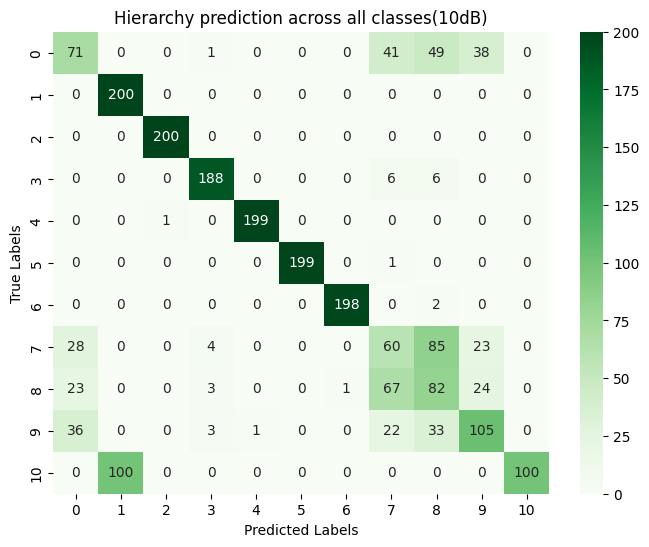

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_labels_np and pred_labels_np are already defined
# Compute the confusion matrix

cm = confusion_matrix(actual_modulations, predicted_modulations)
# , labels=y_label_mods

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
#,xticklabels=actual_modulations,yticklabels=actual_modulations
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Hierarchy prediction across all classes(10dB)')
plt.show()